# Extrapolation, 1

Can a robot do something it wasn't trained to do? Conventional wisdom says that neural networks work fine when **interpolating** between their training instances. However, they can't **extrapolate**. That is, neural networks cannot appropriately perform when placed in a region outside their trained experience. This notebook explores that notion.

## Experiment

In this experiment, we create a robot with a single sonar sensor facing forward. The robot starts at the end of a hallway, and approaches a target location halfway down a long hallway.

In [1]:
import conx as cx
import jyro.simulator as jy
import math
import time

Using TensorFlow backend.
ConX, version 3.7.5


We make an 8m x 2m room, with the robot at the far right end facing to the left. The sonar sensor faces forward and has a max range of 6m. We give the robot a camera just so that we can see the simulated world from the robot's perspective.

In [2]:
def make_world(physics):
    physics.addBox(0, 0, 8, 2, fill="backgroundgreen", wallcolor="gray")

MAX_SENSOR_DISTANCE = 6 # meters
    
def make_robot():
    robot = jy.Pioneer("Pioneer", 7.5, 1, math.pi/2)  #parameters are x, y, heading (in radians)
    robot.addDevice(jy.PioneerFrontSonar(MAX_SENSOR_DISTANCE))
    robot.addDevice(jy.Camera())
    return robot

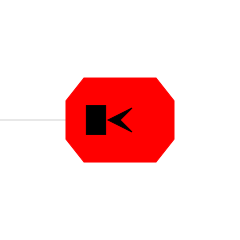

In [3]:
robot = make_robot()
robot

We write a function that provides a teacher to drive the robot. The closer it gets to the target location, the slower the robot moves. The function returns a list of (sensor, power) pairs where the sensor is a scaled distance reading of the sensor, and power is how fast the robot should move given the sensor reading.

In [4]:
def collect_data(simulator):
    data = []
    simulator.reset() # put robot back to where it is defined
    while True:
        scaled_dist = simulator.robot["sonar"].getData()[0]/MAX_SENSOR_DISTANCE
        # The power is a function of distance:
        power = 1.0 - ((1 - scaled_dist)/0.33 * 0.9) 
        robot.move(power, 0)
        data.append([[scaled_dist], [power]])
        simulator.step()
        time.sleep(.1) # don't overwhelm the network
        if power < 0.05:
            break
    return data

We create a visual simulation in order to watch what the robot does.

In [5]:
sim = jy.VSimulator(robot, make_world, size=(700, 180))

Now, we collect the data:

In [6]:
data = collect_data(sim)

We note that the simulator ran for 8.10 seconds, and if it collects a pair of (sensor, power) for every 1/10 of a second, it should have 81 pairs:

In [7]:
len(data)

81

We visualize the collected data:

In [8]:
train = ["Training Data", [pair[1] for pair in data]]

In [9]:
cx.shape(train[0])

(0,)

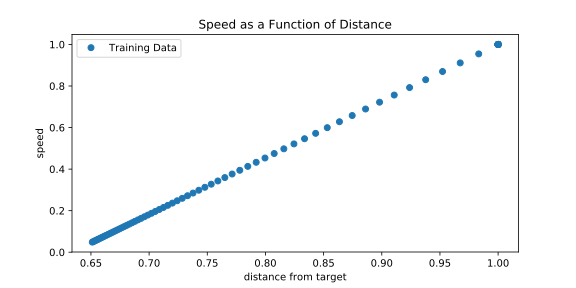

In [10]:
cx.plot(train, 
        title="Speed as a Function of Distance",
        xlabel="distance from target",
        ylabel="speed",
        xs=[pair[0] for pair in data], default_symbol="o")

## Neural Network

Now, we will use the data to train a neural network. The network will have 1-unit in the input layer (for the scaled distance reading), a hidden layer, and a 1-unit output layer to produce the power value.

In [11]:
net = cx.Network("Go To Target")
net.add(cx.Layer("input", 1))
net.add(cx.Layer("hidden", 10, activation="sigmoid"))
net.add(cx.Layer("output", 1, activation = "linear"))
net.connect()
net.compile(loss="mse", optimizer="sgd", lr=.1, momentum=.5)
net.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
hidden (Dense)               (None, 10)                20        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


We load the collected data into the network:

In [12]:
net.dataset.load(data)
net.dataset.info()
net.dataset.summary()

**Dataset**: Dataset for Go To Target

**Information**:
   * name    : None
   * length  : 81

**Input Summary**:
   * shape  : (1,)
   * range  : (0.6511592, 1.0)

**Target Summary**:
   * shape  : (1,)
   * range  : (0.048616093, 1.0)



_________________________________________________________________
Go To Target Dataset:
Patterns    Shape                 Range                         
inputs      (1,)                  (0.6511592, 1.0)              
targets     (1,)                  (0.048616093, 1.0)            
Total patterns: 81
   Training patterns: 81
   Testing patterns: 0
_________________________________________________________________


In [13]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

And now, we train the network on the given data:

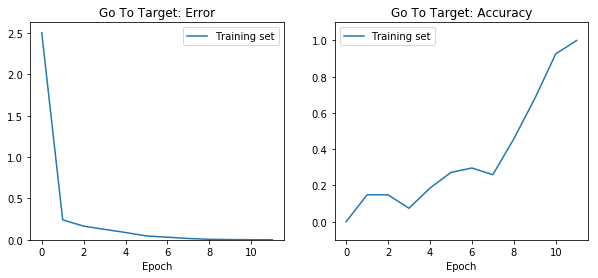

In [14]:
if net.saved():
    net.load()
    net.plot_results()
else:
    net.train(400, accuracy=1.0, tolerance=0.05, batch_size=1, save=True, plot=True)

This is a fairly straightforward problem for the network to solve. If it doesn't get 100% accuracy, you may wish to:

```python
net.delete()
net.reset()
```
and try training again by running the previous cell.

## Testing the Network

In [15]:
test = ["Network", [net.propagate(pair[0])[0] for pair in data]]

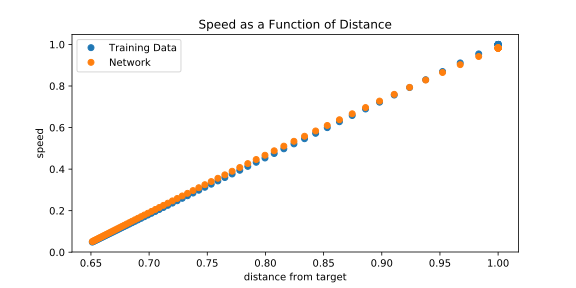

In [16]:
cx.plot([train, test], 
        title="Speed as a Function of Distance",
        xlabel="distance from target",
        ylabel="speed",
        default_symbol="o",
        xs=[pair[0] for pair in data])

## Network-Controlled Robot

In [17]:
def net_brain(robot):
    scaled_distance = robot["sonar"].getData()[0]/6
    output = net.propagate([scaled_distance])[0]
    robot.move(output, 0)
    outputs.append([[scaled_distance], output])
    history.append(robot.getPose())
        
robot.brain = net_brain

In [18]:
outputs = []
history = []
sim.reset()
sim.display()

**Before continuing**, run the experiment above:

1. Press the play button until robot is done moving
2. Press the stop button

In [19]:
trained_range = ["Network interpolation", outputs]

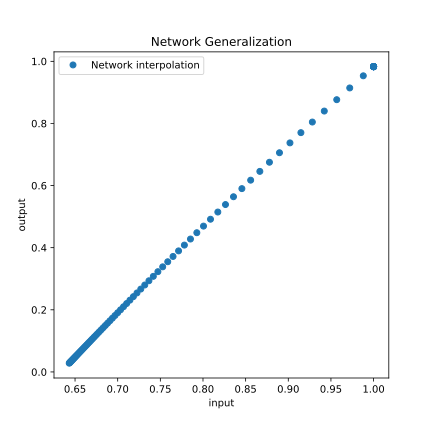

In [20]:
cx.scatter(trained_range,
           title="Network Generalization", 
           xlabel="input", ylabel="output", default_symbol="o")

In [21]:
len(history)

91

Let's make a little movie of the trained experience:

In [22]:
def replay_history(index):
    pose = history[index]
    robot.setPose(*pose)
    sim.update()
    return sim.canvas.render(format="pil")

In [23]:
cx.movie(replay_history, "generalize-in-range.gif", (0, len(history)))

Now, the big question: what does the robot do in positions where t wasn't trained? How does it extrapolate?

To test this, we put the robot in a novel location, and re-run the experiment. (You can skip this next cell, and manually put the robot in any position you wish).

In [24]:
robot.setPose(.5, 1)
sim.update_gui()

First, we reset the variables:

In [25]:
outputs = []
history = []
sim.display()

Take a look at the simulation above. What will the robot do? What is a reasonable action to make?

Let's find out what the robot does.

**Before continuing**, run the experiment above:

1. Press the play button until robot is done moving
2. Press the stop button

In [26]:
cx.movie(replay_history, "generalize-out-range.gif", (0, len(history)))

In [27]:
untrained_range = ["Network extrapolation", outputs]

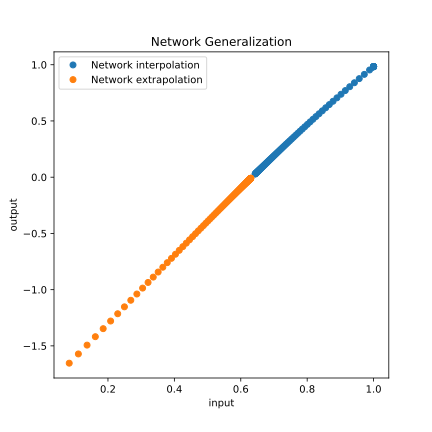

In [28]:
cx.scatter([trained_range, untrained_range],
           title="Network Generalization", 
           xlabel="input", ylabel="output", default_symbol="o")

## Conclusion

The robot was tested in a region for which there was no training data, and so it had to **extrapolate** from what it knew, to a novel scenario. It did. Although it had never been trained to move backwards, it was able to determine that the correct action was to move backwards. In fact, it shows that the further the robot is from the target location, the faster it moves towards it.

How was the robot able to extrapolate beyond its training? Well, the network's ability to move backwards when it was never trained to do so is a bit of an overstatement of what the network is doing. Because the output is a single unit for "power" and he robot can be driven by a single value with negative meaning to backup and positive meaning to move forward, it really doesn't make a distinction between forward/backward... it merely converts the distance into a value. 

However, the network has done what has been claimed to be impossible, albeit in a simple fashion. What this suggests is that extrapolation to unknown regions may be possible, if the space of actions is arranged in a proper way.